In [27]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans

%matplotlib inline

RFM Analysis
============
In this ipynb file, We aim to create columns below
- customer_unique_id: unique key
- recency: days since last purchase
- frequency: number of purchases
- monetary: total amount of purchases
- recency_cluster
- frequency_cluster
- monetary_cluster


In [28]:
## Use 4 necessary datasets
df_customers = pd.read_csv('datasets/olist_customers_dataset.csv')
# df_geolocation = pd.read_csv('datasets/olist_geolocation_dataset.csv')
df_order_items = pd.read_csv('datasets/olist_order_items_dataset.csv')
df_order_payments = pd.read_csv('datasets/olist_order_payments_dataset.csv')
# df_order_reviews = pd.read_csv('datasets/olist_order_reviews_dataset.csv')
df_orders = pd.read_csv('datasets/olist_orders_dataset.csv')
# df_products = pd.read_csv('datasets/olist_products_dataset.csv')
# df_sellers = pd.read_csv('datasets/olist_sellers_dataset.csv')
# df_product_category_name = pd.read_csv('datasets/product_category_name_translation.csv')

In [29]:
## Merge datasets
df1 = df_order_payments.merge(df_order_items, on='order_id')
df2 = df1.merge(df_orders, on='order_id')
df = df2.merge(df_customers, on='customer_id') ## Memo: 'customer_id is foreign key, not unique'

print(df.shape)
df.head()

(117601, 22)


,order_id,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,...,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,1,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,2018-05-02 22:15:09,79.80,...,delivered,2018-04-25 22:01:49,2018-04-25 22:15:09,2018-05-02 15:20:00,2018-05-09 17:36:51,2018-05-22 00:00:00,708ab75d2a007f0564aedd11139c7708,39801,teofilo otoni,MG
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,1,a630cc320a8c872f9de830cf121661a3,eaf6d55068dea77334e8477d3878d89e,2018-07-02 11:18:58,17.00,...,delivered,2018-06-26 11:01:38,2018-06-26 11:18:58,2018-06-28 14:18:00,2018-06-29 20:32:09,2018-07-16 00:00:00,a8b9d3a27068454b1c98cc67d4e31e6f,2422,sao paulo,SP
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71,1,2028bf1b01cafb2d2b1901fca4083222,cc419e0650a3c5ba77189a1882b7556a,2017-12-26 09:52:34,56.99,...,delivered,2017-12-12 11:19:55,2017-12-14 09:52:34,2017-12-15 20:13:22,2017-12-18 17:24:41,2018-01-04 00:00:00,6f70c0b2f7552832ba46eb57b1c5651e,2652,sao paulo,SP
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,1,548e5bfe28edceab6b51fa707cc9556f,da8622b14eb17ae2831f4ac5b9dab84a,2017-12-12 12:13:20,89.90,...,delivered,2017-12-06 12:04:06,2017-12-06 12:13:20,2017-12-07 20:28:28,2017-12-21 01:35:51,2018-01-04 00:00:00,87695ed086ebd36f20404c82d20fca87,36060,juiz de fora,MG
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45,1,386486367c1f9d4f587a8864ccb6902b,cca3071e3e9bb7d12640c9fbe2301306,2018-05-31 16:14:41,113.57,...,delivered,2018-05-21 13:59:17,2018-05-21 16:14:41,2018-05-22 11:46:00,2018-06-01 21:44:53,2018-06-13 00:00:00,4291db0da71914754618cd789aebcd56,18570,conchas,SP


In [30]:
## datatypes for each column
df.dtypes

##some data objects should be converted to datetime

order_id                          object
payment_sequential                 int64
payment_type                      object
payment_installments               int64
payment_value                    float64
order_item_id                      int64
product_id                        object
seller_id                         object
shipping_limit_date               object
price                            float64
freight_value                    float64
customer_id                       object
order_status                      object
order_purchase_timestamp          object
order_approved_at                 object
order_delivered_carrier_date      object
order_delivered_customer_date     object
order_estimated_delivery_date     object
customer_unique_id                object
customer_zip_code_prefix           int64
customer_city                     object
customer_state                    object
dtype: object

In [31]:
## Convert data object to datetime
df_columns = [
  'shipping_limit_date',
  'order_purchase_timestamp',
  'order_approved_at',
  'order_delivered_carrier_date',
  'order_delivered_customer_date',
  'order_estimated_delivery_date'
]

for col in df_columns:
  df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')

## Feature Engineering
Create new features from the original dataset

In [32]:
## order purchase year, month, day, hour
df['order_purchase_year'] = df['order_purchase_timestamp'].dt.year
df['order_purchase_month'] = df['order_purchase_timestamp'].dt.month
df['order_purchase_day'] = df['order_purchase_timestamp'].dt.day ## We can delete this column because we have day_of_week
df['order_purchase_hour'] = df['order_purchase_timestamp'].dt.hour

## order purchase dayofweek
df['order_purchase_day_of_week'] = df['order_purchase_timestamp'].dt.dayofweek. \
    map({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'})

df['delivery_ahead_days'] = (df['order_delivered_customer_date'] - df['order_estimated_delivery_date']).dt.days

## Todo: add more features


## Data Cleaning
- Check for missing values
- Our EDA shows that the first and last 2-3 months have less data. We will remove these months from the dataset.



In [33]:
## Data Cleaning task here

## Recency

In [34]:
## We use df_rfm for Recency, Frequency, Monetary
df_rfm = pd.DataFrame(df['customer_unique_id'])
df_rfm.columns = ['customer_unique_id']

## Get the latest purchase date for each customer
df_latest_purchase = df.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()
df_latest_purchase.columns = ['customer_unique_id', 'latest_purchase_date']
## Get Recency
df_latest_purchase['recency'] = (
    df_latest_purchase['latest_purchase_date'].max() - df_latest_purchase['latest_purchase_date']
).dt.days

## Merge Recency to df_rfm
df_rfm = df_rfm.merge(df_latest_purchase, on='customer_unique_id')

df_rfm.head()

,customer_unique_id,latest_purchase_date,recency
0,708ab75d2a007f0564aedd11139c7708,2018-04-25 22:01:49,130
1,a8b9d3a27068454b1c98cc67d4e31e6f,2018-06-26 11:01:38,68
2,6f70c0b2f7552832ba46eb57b1c5651e,2017-12-12 11:19:55,264
3,87695ed086ebd36f20404c82d20fca87,2017-12-06 12:04:06,270
4,4291db0da71914754618cd789aebcd56,2018-08-01 08:29:38,33


/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/9r/bsd76cw537n872tfj2lhrmfc0000gn/T/ipykernel_93886/2131498726.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recency["clusters"] = kmeans.labels_
/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders

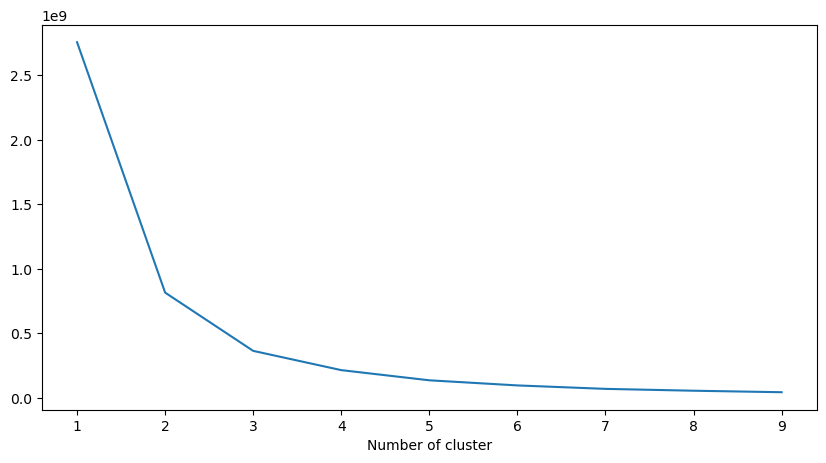

In [35]:
## Use k-means to get recency_cluster
## First of all, we need to know the optimal number of clusters
sse={}
df_recency = df_rfm[['recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_recency)
    df_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_

plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [39]:
## The plot shows that the optimal number is 4 or 5. We choose 4
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_rfm[['recency']])
df_rfm['recency_cluster'] = kmeans.predict(df_rfm[['recency']])

## recency_cluster's number is not meaningful, we need to change it to meaningful number
def order_cluster(cluster_column_name, target_column_name,df):
    df_tmp = df.groupby(cluster_column_name)[target_column_name].mean().reset_index()
    df_tmp = df_tmp.sort_values(by=target_column_name, ascending=False).reset_index(drop=True)
    df_tmp['index'] = df_tmp.index

    df_output = pd.merge(
        df,
        df_tmp[[cluster_column_name,'index']],
        on=cluster_column_name
    )
    df_output = df_output.drop([cluster_column_name], axis=1)
    df_output = df_output.rename(columns = {"index": cluster_column_name})
    return df_output

df_rfm = order_cluster('recency_cluster', 'recency', df_rfm)

df_rfm.groupby('recency_cluster')['recency'].describe()

/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,count,mean,std,min,25%,50%,75%,max
recency_cluster,,,,,,,,
0,20583.0,490.674634,59.104594,406.0,444.0,481.0,533.0,728.0
1,31047.0,320.158663,43.961357,255.0,281.0,313.0,357.0,405.0
2,34040.0,188.087985,35.200746,128.0,158.0,188.0,219.0,254.0
3,31931.0,66.785224,36.031613,0.0,33.0,67.0,100.5,127.0


In [ ]:
## The mean values show the recency_cluster is meaningful

## Frequency